Use OpenAI to plot an option payoff diagram that the user describes!

Response Text: [
    {"type": "call", "strike": 110, "quantity": 2, "premium": 0.5}
]
Parsed strategy: [{'type': 'call', 'strike': 110, 'quantity': 2, 'premium': 0.5}]


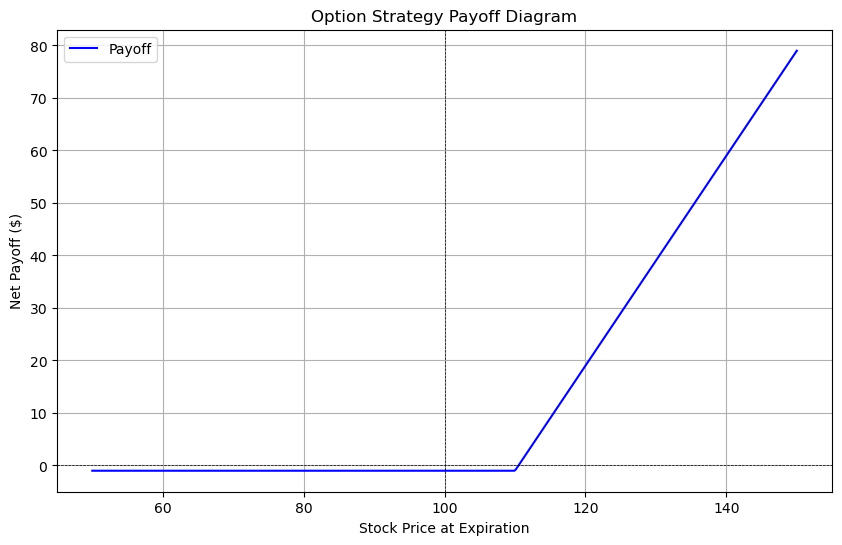

In [5]:
#Import Modules
from openai import OpenAI
import json
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

# Load API key stored in .env file
load_dotenv()

client = OpenAI()

# Define parsing function
def parse_option_strategy(user_input):
    prompt = f"""You are an expert in options trading. A user describes an option strategy. Return the structured data in JSON format with:
    - 'type' (call/put)
    - 'strike' (strike price)
    - 'quantity' (positive for long, negative for short)
    - 'premium' (price paid or received for each option)
    
    Example:
    User: "I bought 2 calls at a $100 strike for $5 and sold 1 call at $110 strike for $3"
    Response: 
    [
        {{"type": "call", "strike": 100, "quantity": 2, "premium": 5}},
        {{"type": "call", "strike": 110, "quantity": -1, "premium": 3}}
    ]
    
    User: "{user_input}"
    Response:
    """
    
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are an expert options strategy parser."},
            {"role": "user", "content": prompt}
        ]
    )
    
    # Debugging: Print the raw response
    response_text = response.choices[0].message.content.strip()
    print("Response Text:", response_text)  # Check what the response looks like

    try:
        # Parse the response as JSON
        strategy = json.loads(response_text)
        return strategy
    except json.JSONDecodeError as e:
        print("Failed to decode JSON:", e)
        return []  # Return an empty list or handle this case as needed



# Payoff calculation
def calculate_payoff(strategy, stock_prices):
    payoff = np.zeros_like(stock_prices)
    
    for option in strategy:
        if option["type"] == "call":
            intrinsic = np.maximum(stock_prices - option["strike"], 0)
        elif option["type"] == "put":
            intrinsic = np.maximum(option["strike"] - stock_prices, 0)
        
        payoff += option["quantity"] * (intrinsic - option["premium"])
    
    return payoff

# Plot payoff diagram
def plot_payoff(strategy, stock_prices):
    payoff = calculate_payoff(strategy, stock_prices)
    
    plt.figure(figsize=(10, 6))
    plt.plot(stock_prices, payoff, label="Payoff", color='blue')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(stock_prices[len(stock_prices) // 2], color='black', linestyle='--', linewidth=0.5)
    plt.title("Option Strategy Payoff Diagram")
    plt.xlabel("Stock Price at Expiration")
    plt.ylabel("Net Payoff ($)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the code
stock_prices = np.linspace(50, 150, 500)  # Example range of stock prices
user_input = "I bought 2 calls at a $110 strike for $0.5"
strategy = parse_option_strategy(user_input)
print("Parsed strategy:", strategy)  # Debugging step to check parsed strategy
plot_payoff(strategy, stock_prices)
